In [1]:
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [3]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length):  
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx} | Loss: {loss.item()}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, plot=True):
    train_losses = []
    for epoch in range(num_epochs):
        if plot: visualize_progress(model, device)
        print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/STR_model_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth'):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 100
batch_size = 16 # Archibald it is 32
checkpoint_interval = 1
learning_rate = 0.001
lr_decay = 0.9

In [5]:
# Load data
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train'
dataset = HandwritingDataset(root_dir, batch_size, device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 2740/2740 [00:25<00:00, 107.09it/s]


In [9]:
# Model
model = STR_Model().to(device)
set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=20)

Best model: STR_model_1_15741.pth


Image id: 9541


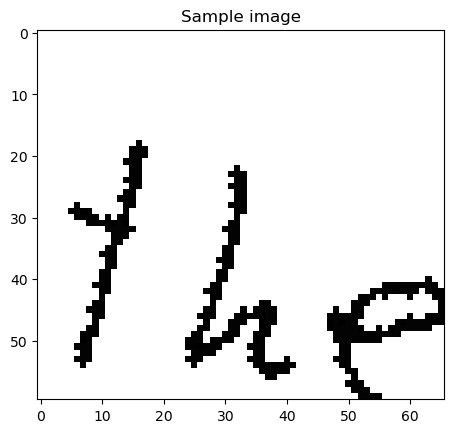

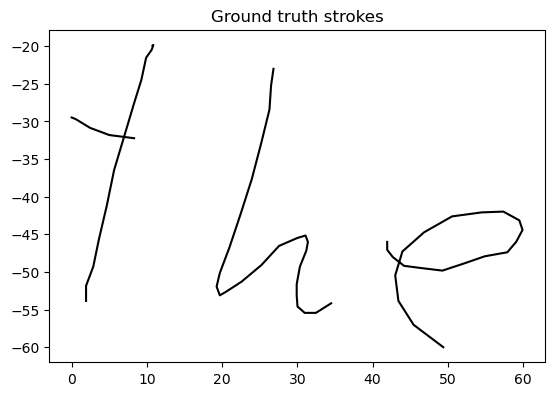

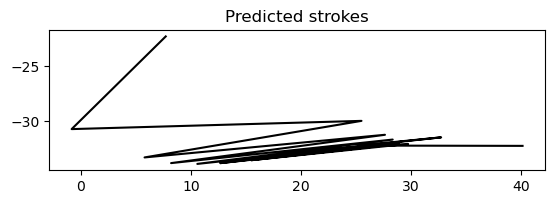

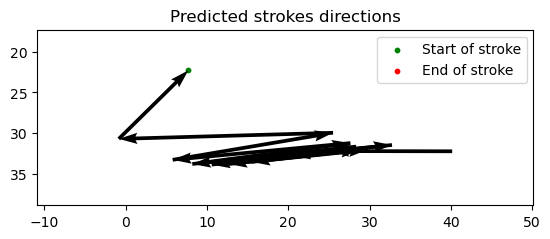

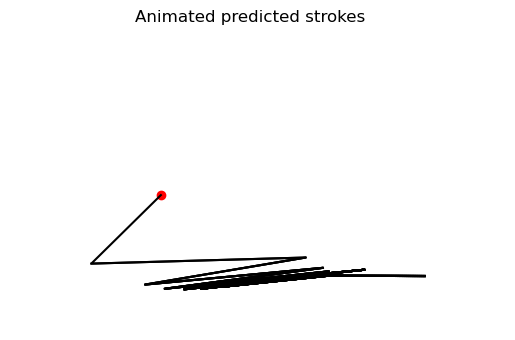

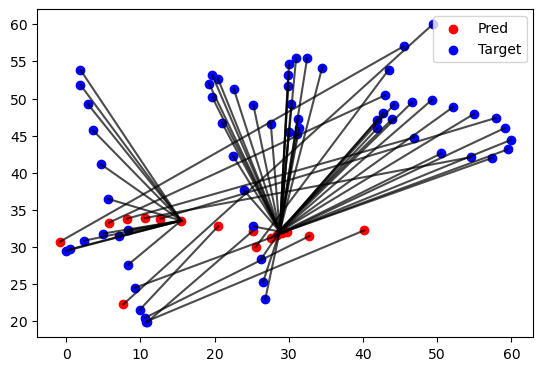

Epoch 1:   0%|          | 0/2740 [00:00<?, ?it/s]

   Batch: 0 | Loss: 829.6167234737168
   Batch: 100 | Loss: 759.8204607994358
   Batch: 200 | Loss: 828.0364503439994
   Batch: 300 | Loss: 941.6702621237674
   Batch: 400 | Loss: 984.3823884199968
   Batch: 500 | Loss: 1148.2169918157754
   Batch: 600 | Loss: 966.2544802725017
   Batch: 700 | Loss: 1264.4105765166526
   Batch: 800 | Loss: 1062.145853687295
   Batch: 900 | Loss: 1238.6718962170871
   Batch: 1000 | Loss: 1143.2347660302096
   Batch: 1100 | Loss: 1182.8796499216705
   Batch: 1200 | Loss: 1428.0128496100938
   Batch: 1300 | Loss: 1306.1860403233352
   Batch: 1400 | Loss: 1484.578720939141
   Batch: 1500 | Loss: 1428.5244455581112
   Batch: 1600 | Loss: 1549.5668425554884
   Batch: 1700 | Loss: 1468.9166729655033
   Batch: 1800 | Loss: 1575.724173178809
   Batch: 1900 | Loss: 1735.1400249004812
   Batch: 2000 | Loss: 1616.4664127423475
   Batch: 2100 | Loss: 1811.0956188586108
   Batch: 2200 | Loss: 1804.2271125772745
   Batch: 2300 | Loss: 2067.896266339367
   Batch: 2400

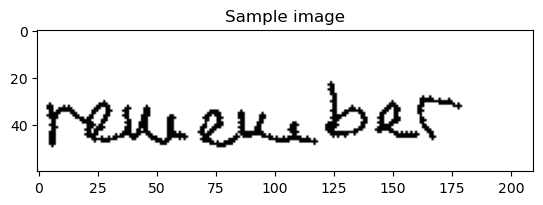

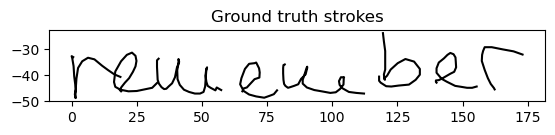

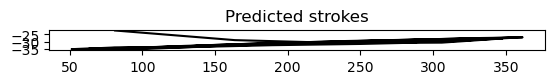

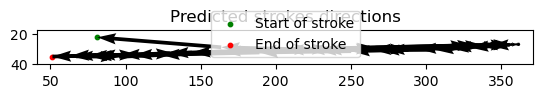

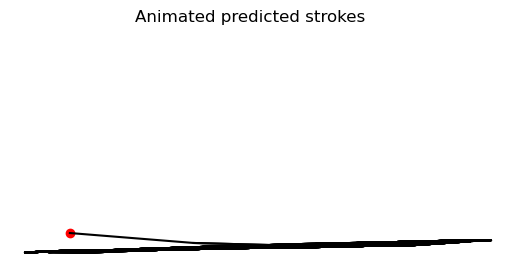

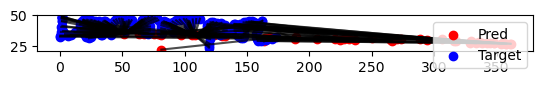

Epoch 2:   0%|          | 0/2740 [00:00<?, ?it/s]

   Batch: 0 | Loss: 3353.7452869572735
   Batch: 100 | Loss: 793.4205714971501
   Batch: 200 | Loss: 864.7831702889802
   Batch: 300 | Loss: 949.2719851107729
   Batch: 400 | Loss: 994.2406604232555
   Batch: 500 | Loss: 1065.6599908364267
   Batch: 600 | Loss: 947.916166464367
   Batch: 700 | Loss: 1192.196267309531
   Batch: 800 | Loss: 1110.263537191857
   Batch: 900 | Loss: 1247.288735929069
   Batch: 1000 | Loss: 1117.4676998292725
   Batch: 1100 | Loss: 1094.4583300966228
   Batch: 1200 | Loss: 1276.28422788502
   Batch: 1300 | Loss: 1249.7004187691527
   Batch: 1400 | Loss: 1494.6353044926227
   Batch: 1500 | Loss: 1481.5645319262478
   Batch: 1600 | Loss: 1369.2027969863861
   Batch: 1700 | Loss: 1429.915046983533
   Batch: 1800 | Loss: 1517.9351805166903
   Batch: 1900 | Loss: 1896.2551420135214
   Batch: 2000 | Loss: 1584.856681417627
   Batch: 2100 | Loss: 1802.2644203526356
   Batch: 2200 | Loss: 1785.2903435299368
   Batch: 2300 | Loss: 1976.389619435134
   Batch: 2400 | L

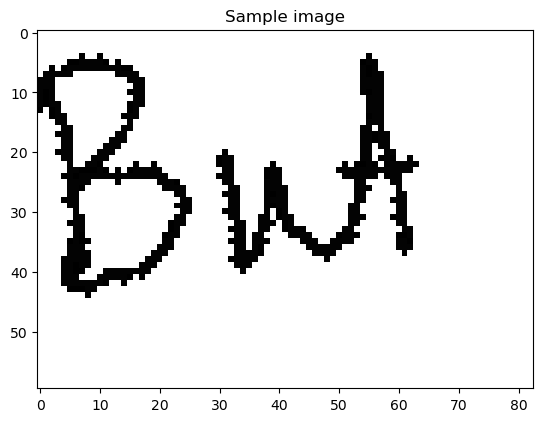

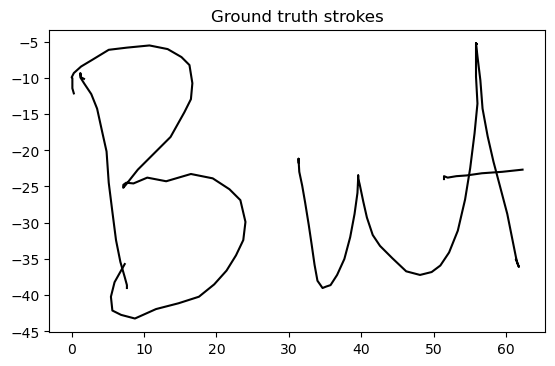

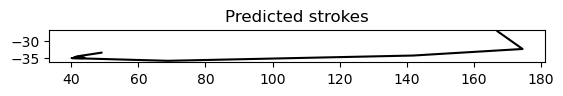

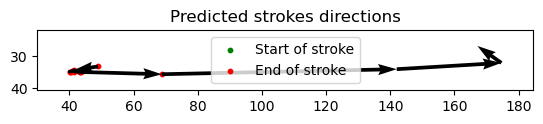

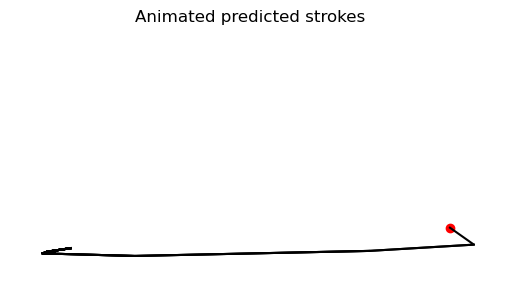

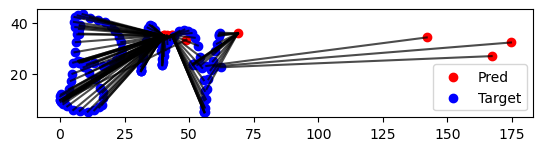

Epoch 3:   0%|          | 0/2740 [00:00<?, ?it/s]

   Batch: 0 | Loss: 3565.0376494088264
   Batch: 100 | Loss: 736.0169502031991
   Batch: 200 | Loss: 833.3835956292191
   Batch: 300 | Loss: 952.450792976136
   Batch: 400 | Loss: 939.5732872954063
   Batch: 500 | Loss: 1052.173827808572
   Batch: 600 | Loss: 958.628649793654
   Batch: 700 | Loss: 1131.1593939242596
   Batch: 800 | Loss: 1048.2140003616378
   Batch: 900 | Loss: 1233.790847324882
   Batch: 1000 | Loss: 1189.7138945050217
   Batch: 1100 | Loss: 1105.4752158970916
   Batch: 1200 | Loss: 1153.8415239304284
   Batch: 1300 | Loss: 1292.786836987734
   Batch: 1400 | Loss: 1532.2524132051658
   Batch: 1500 | Loss: 1324.2907862850018
   Batch: 1600 | Loss: 1664.0437650467031
   Batch: 1700 | Loss: 1530.9971712951256
   Batch: 1800 | Loss: 1567.994796021534
   Batch: 1900 | Loss: 1513.1641211819735
   Batch: 2000 | Loss: 1829.757086357364
   Batch: 2100 | Loss: 1839.6903144778405
   Batch: 2200 | Loss: 1666.720068543987
   Batch: 2300 | Loss: 2229.713545065514
   Batch: 2400 | L

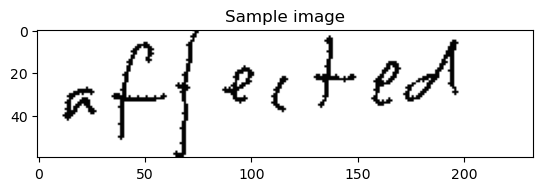

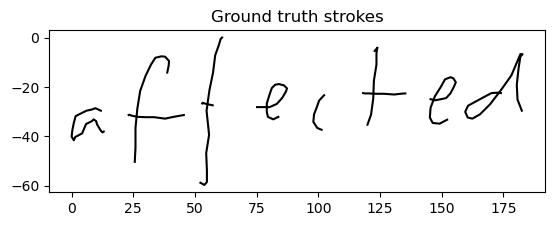

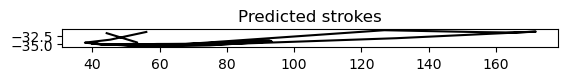

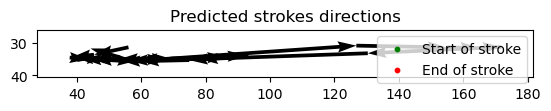

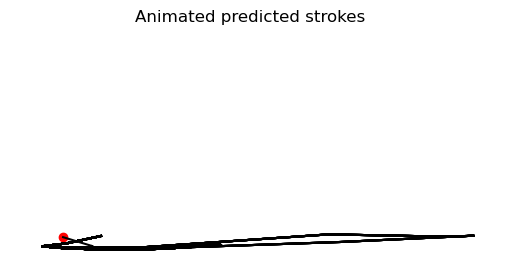

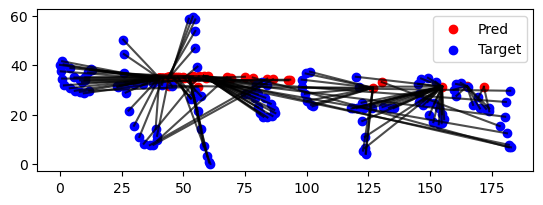

Epoch 4:   0%|          | 0/2740 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1428.2115918356672
   Batch: 100 | Loss: 814.4486160954107
   Batch: 200 | Loss: 794.9850235578457
   Batch: 300 | Loss: 1029.300688316112
   Batch: 400 | Loss: 921.595227157942
   Batch: 500 | Loss: 1015.4241220590075
   Batch: 600 | Loss: 962.6494581050395
   Batch: 700 | Loss: 1154.2631254870187
   Batch: 800 | Loss: 1120.7082404795756
   Batch: 900 | Loss: 1074.6558822443835
   Batch: 1000 | Loss: 1117.6788840518825
   Batch: 1100 | Loss: 1042.4288821693904
   Batch: 1200 | Loss: 1226.0594057145697
   Batch: 1300 | Loss: 1348.6742127035925
   Batch: 1400 | Loss: 1441.560274615732
   Batch: 1500 | Loss: 1199.544693804295
   Batch: 1600 | Loss: 1544.3638285668335
   Batch: 1700 | Loss: 1717.2108315071503
   Batch: 1800 | Loss: 1544.2961901037575
   Batch: 1900 | Loss: 1282.5595986933422
   Batch: 2000 | Loss: 1934.0042744804234
   Batch: 2100 | Loss: 1682.4865841211613
   Batch: 2200 | Loss: 1649.7827582549048
   Batch: 2300 | Loss: 1906.055968668113
   Batch: 240

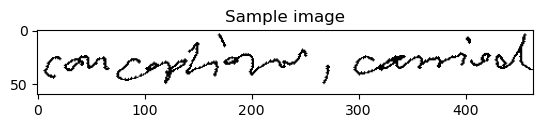

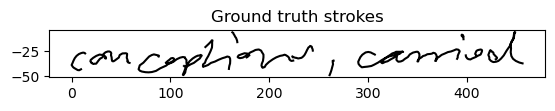

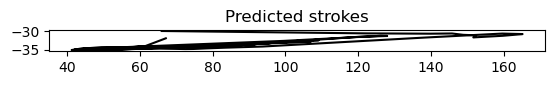

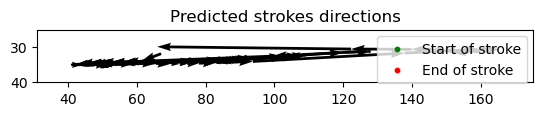

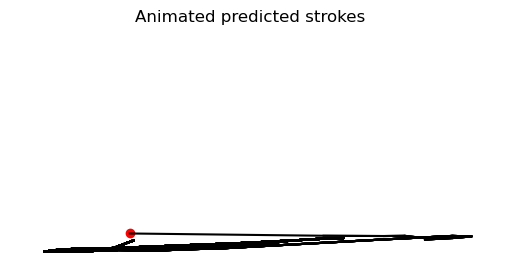

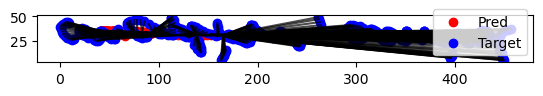

Epoch 5:   0%|          | 0/2740 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1765.1634149112795
   Batch: 100 | Loss: 760.4043506037416
   Batch: 200 | Loss: 818.1716542324966
   Batch: 300 | Loss: 949.2306853069016
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/taha_adeel/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14164/3918437477.py", line 2, in <module>
    losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, plot=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_14164/3319794716.py", line 24, in model_fit
    loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_14164/3319794716.py", line 9, in train
    loss = loss_function(output, target)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/taha_adeel/anaconda3/envs/tensorflow/lib/python3.11/site-pac

In [10]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, plot=True)